# Player Profile and Market Value Analysis

In [2]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting the path to access the data
path = r"C:\Users\Mihir\8_CAPSTONE PROJECT\S1_Data_Preprocessing\1_Preprocessing_Data_&_EDA_LEVEL_0\\"
path

'C:\\Users\\Mihir\\8_CAPSTONE PROJECT\\S1_Data_Preprocessing\\1_Preprocessing_Data_&_EDA_LEVEL_0\\\\'

In [4]:
# reading required csv files
appearances = pd.read_csv(path + "appearances_df_no_win.csv")
players = pd.read_csv(path + "players_df_winsorised.csv")
games = pd.read_csv(path + "games_df_winsorised.csv")
game_events = pd.read_csv(path + "game_events_df_no_win.csv")
game_lineups = pd.read_csv(path + "game_lineups_df_no_win.csv")
test = pd.read_csv(path + "test data.csv")

# 1. How does player age impact their market value ?

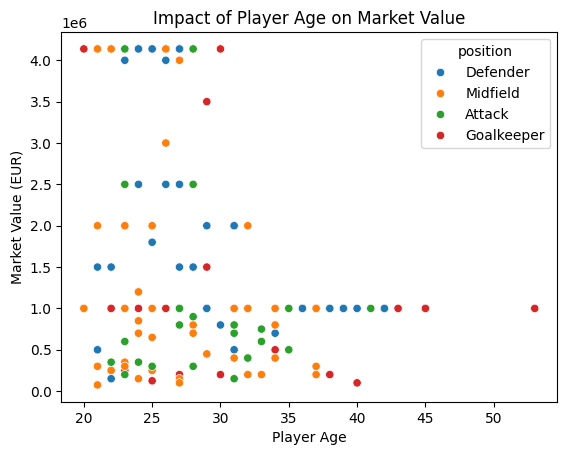

In [6]:
# Calculate age based on date_of_birth and current date
curr_date = 2024
age = [int(curr_date - int(x[:4])) for x in players['date_of_birth']]

players['age'] = age

# Visualize how age impacts market value
sns.scatterplot(data=players, x='age', y='market_value_in_eur', hue='position')
plt.title("Impact of Player Age on Market Value")
plt.xlabel("Player Age")
plt.ylabel("Market Value (EUR)")
plt.show()

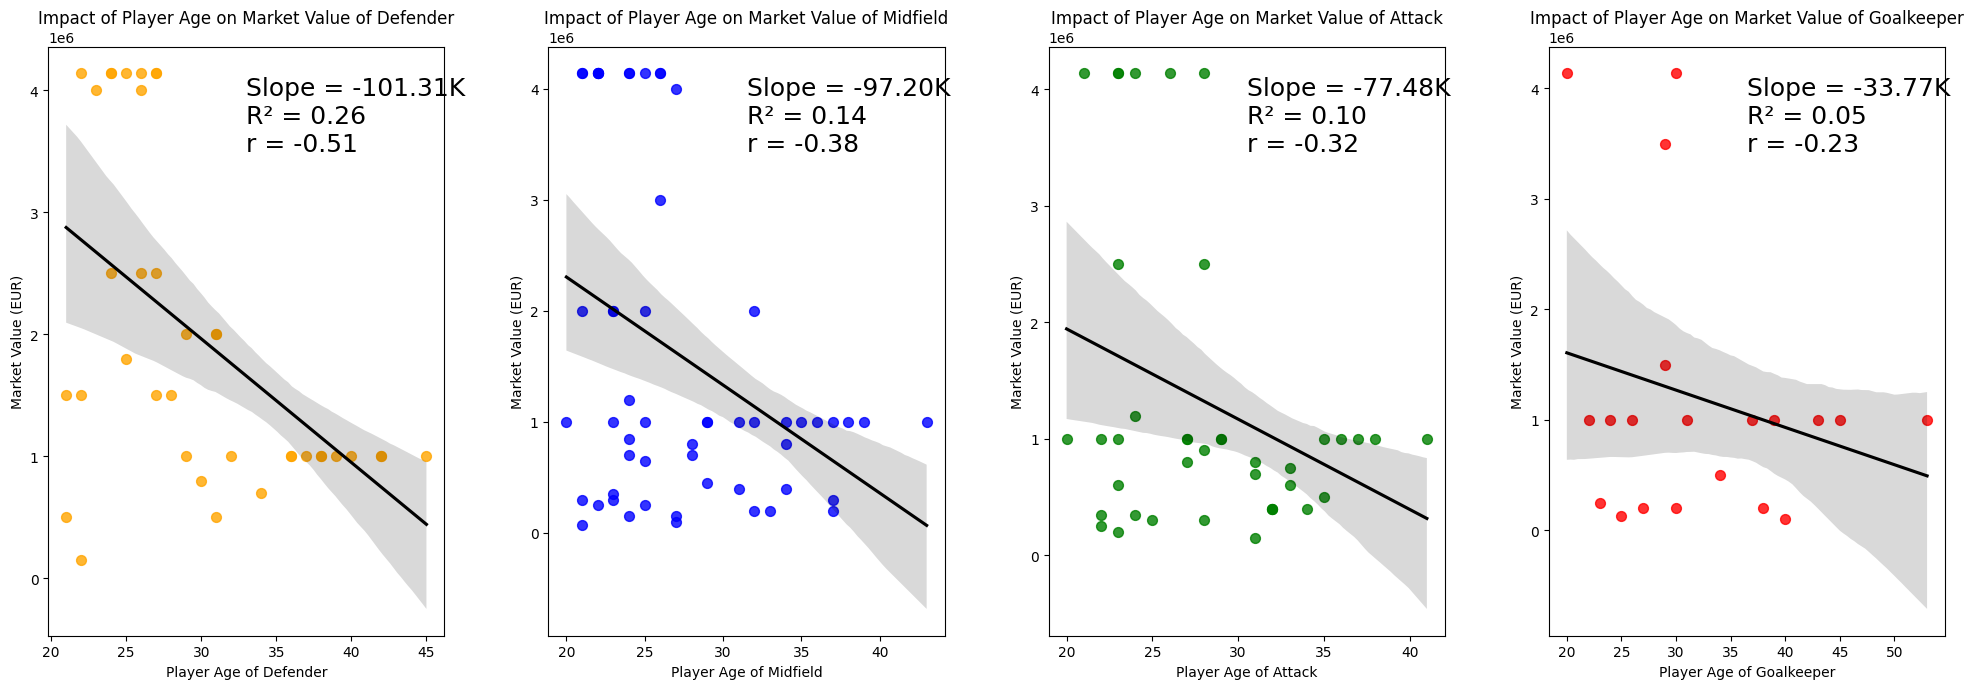

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

colors = ['orange', 'blue', 'green', 'red']  # Ensure the number of colors matches the positions
positions = players['position'].unique()

# Adjust the number of subplots based on unique positions
fig, ax = plt.subplots(1, len(positions), figsize=(20, 7))

for index, p in enumerate(positions):
    # Filter data for the current position
    data = players[players['position'] == p]

    # Calculate Pearson correlation coefficient
    corr_coef = np.corrcoef(data['age'], data['market_value_in_eur'])[0, 1]
    
    # Prepare the data for regression
    X = np.array(data['age']).reshape(-1, 1)
    y = data['market_value_in_eur']
    
    # Fit the linear regression model
    model = LinearRegression().fit(X, y)
    
    # Predict the values and calculate R² score
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    slope = model.coef_
    # Scatter plot with a regression line
    sns.regplot(x='age', y='market_value_in_eur', data=data, ax=ax[index], color=colors[index], scatter_kws={'s':50}, line_kws={'color':'black'})
    
    # Set title and labels
    ax[index].set_title(f"Impact of Player Age on Market Value of {p}")
    ax[index].set_xlabel(f"Player Age of {p}")
    ax[index].set_ylabel("Market Value (EUR)")

    # Add R² score and correlation coefficient on the plot
    ax[index].text(0.50, 0.95, f'Slope = {slope[0]/1000:.2f}K\nR² = {r2:.2f}\nr = {corr_coef:.2f}', transform=ax[index].transAxes, fontsize=18, verticalalignment='top')
    
plt.tight_layout()  
plt.show()

# 2. Which players have the highest market value, and are they performing up to that value?

In [9]:
# Merging players and appearances data
player_performance = pd.merge(players, appearances, on='player_id')
top_market_value_players = player_performance.groupby("name")[['goals', 
                                                               'assists', 'highest_market_value_in_eur',
                                                               "market_value_in_eur", 
                                                               'minutes_played']].mean()

top_market_value_players["total_contribution"] = top_market_value_players["goals"] + top_market_value_players["assists"]

display(top_market_value_players[["total_contribution", 
                          'highest_market_value_in_eur']].sort_values(["total_contribution", 
                                                                       'highest_market_value_in_eur'], ascending= [False, False]).head(3)) # had used "market_value_in_eur" before

display(top_market_value_players[["total_contribution", 
                          'highest_market_value_in_eur']].sort_values(['highest_market_value_in_eur', 
                                                                       "total_contribution"], ascending= [False, True]).head(3)) # had used "market_value_in_eur" before

,total_contribution,highest_market_value_in_eur
name,,
Joseph Efford,0.833333,600000.0
Aron Johannsson,0.545455,4000000.0
Jozy Altidore,0.505882,9000000.0


,total_contribution,highest_market_value_in_eur
name,,
Cameron Carter-Vickers,0.00000,11468750.0
Chris Richards,0.00000,11468750.0
Tyler Adams,0.09375,11468750.0


# 3. How does a player’s performance influence their current market value?

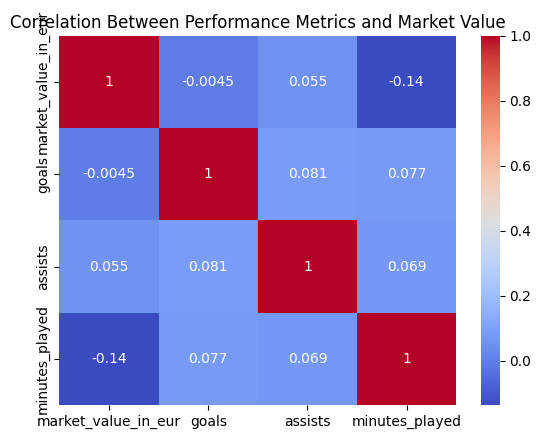

In [43]:
# Merging players and appearances data
player_performance = pd.merge(players, appearances, on='player_id')

# Correlation between performance metrics , minutes played and market value
performance_cols = ['market_value_in_eur', 'goals', 'assists', 'minutes_played']
correlation = player_performance[performance_cols].corr()

# Plot correlation heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Between Performance Metrics and Market Value")
plt.show()

## Using Multiple Linear Regression 
### to predict the market value based on the goals, minutes played and assists made by player

In [46]:
# Import the required modules required
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

# Scale the data for training data
scaler = StandardScaler()
performance_corr_scaled = pd.DataFrame(scaler.fit_transform(player_performance[performance_cols]), 
                                       columns = player_performance[performance_cols].columns)

# Independent and Dependent Variables
X = performance_corr_scaled[['goals', 'assists', 'minutes_played']].values
y = performance_corr_scaled['market_value_in_eur'].values
print("X Shape: ", X.shape)
print("y Shape: ", y.shape)
print()
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X Shape:  (3568, 3)
y Shape:  (3568,)

X_train shape:  (2854, 3)
X_test shape:  (714, 3)
y_train shape:  (2854,)
y_test shape:  (714,)


In [48]:
# Train the Multiple Linear Regression Model on training data
model = LinearRegression()
model.fit(X_train, y_train)

# Score of accuracy on Training set
print("Training Accuracy Score: ", model.score(X_train, y_train))

# print intercept and slope of the model
print("Intercept (c)", model.intercept_)
print("Slopes for each independent Variable (m)", model.coef_)

# Predicted values on the training set
y_pred_train = model.predict(X_train)
print('y_pred_train: ', y_pred_train)

Training Accuracy Score:  0.0236228123873643
Intercept (c) -0.005991580427139238
Slopes for each independent Variable (m) [ 0.00124984  0.06145059 -0.14337379]
y_pred_train:  [ 0.26276019 -0.11596969 -0.11596969 ... -0.11596969 -0.11596969
  0.10080255]


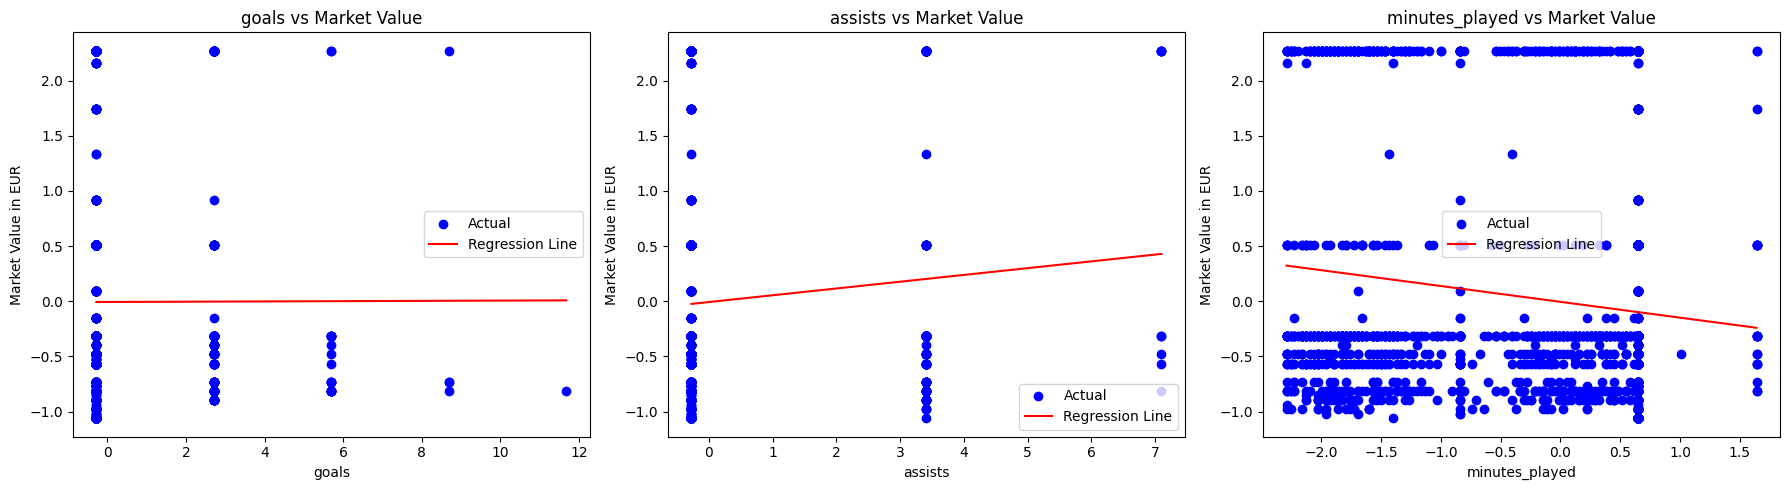

In [50]:
# Create scatter plots for each independent variable against 'market_value_in_eur'
features = ['goals', 'assists', 'minutes_played']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(features):
    axes[i].scatter(X_train[:, i], y_train, label='Actual', color='blue')

    # Plot the regression line
    # To draw the regression line, we need to predict y-values for a range of X-values.
    X_range = np.linspace(X_train[:, i].min(), X_train[:, i].max(), 100).reshape(-1, 1)
    if feature == 'goals':
        X_input = np.column_stack((X_range, np.full_like(X_range, X_train[:, 1].mean()), np.full_like(X_range, X_train[:, 2].mean())))
    elif feature == 'assists':
        X_input = np.column_stack((np.full_like(X_range, X_train[:, 0].mean()), X_range, np.full_like(X_range, X_train[:, 2].mean())))
    else:  # minutes_played
        X_input = np.column_stack((np.full_like(X_range, X_train[:, 0].mean()), np.full_like(X_range, X_train[:, 1].mean()), X_range))
    
    # Predict values using the model
    y_pred_line = model.predict(X_input)
    
    # Plot the regression line
    axes[i].plot(X_range, y_pred_line, color='red', label='Regression Line')

    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Market Value in EUR')
    axes[i].set_title(f'{feature} vs Market Value')
    axes[i].legend()

plt.tight_layout()
plt.show()

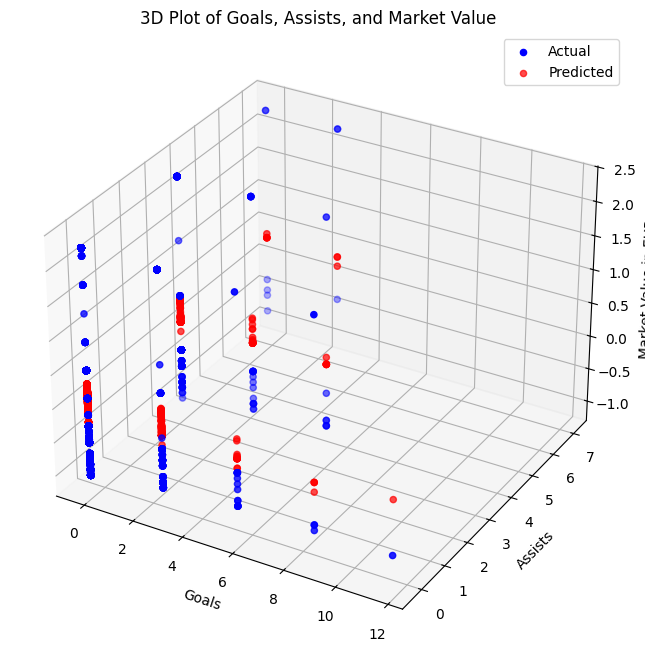

In [51]:
# Create a 3D plot using the first two features: 'goals' and 'assists'
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', label='Actual')

# Plot predicted points
ax.scatter(X_train[:, 0], X_train[:, 1], y_pred_train, color='red', alpha=0.7, label='Predicted')

# Labels
ax.set_xlabel('Goals')
ax.set_ylabel('Assists')
ax.set_zlabel('Market Value in EUR')

# Title
ax.set_title('3D Plot of Goals, Assists, and Market Value')

ax.legend()

plt.show()

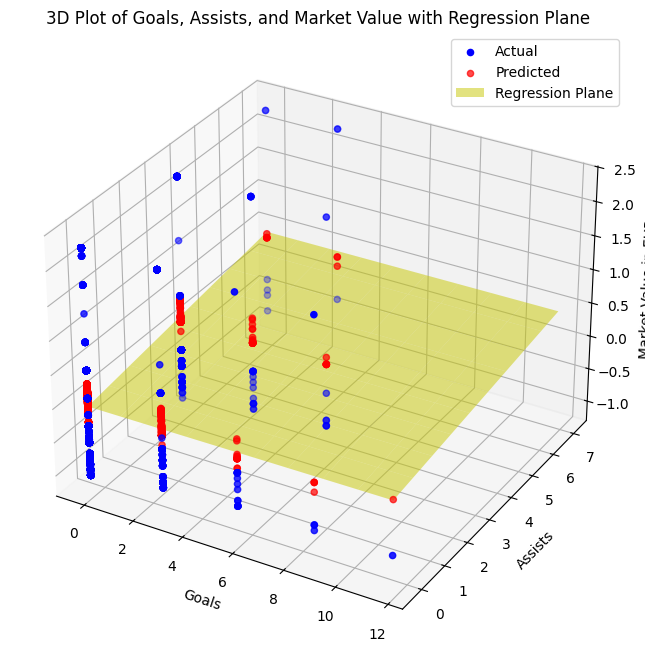

In [54]:
# Create a 3D plot using the first two features: 'goals' and 'assists' REGRESSION PLANE
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot actual points
ax.scatter(X_train[:, 0], X_train[:, 1], y_train, color='blue', label='Actual')

# Plot predicted points
ax.scatter(X_train[:, 0], X_train[:, 1], y_pred_train, color='red', alpha=0.7, label='Predicted')

# Create a grid for 'goals' and 'assists' to draw the regression plane
goals_range = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 10)
assists_range = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 10)
goals_grid, assists_grid = np.meshgrid(goals_range, assists_range)

# Use the regression model to predict the market value over the grid
minutes_played_avg = X_train[:, 2].mean()  # Use the average 'minutes_played' for the regression plane
Z = model.intercept_ + model.coef_[0] * goals_grid + model.coef_[1] * assists_grid + model.coef_[2] * minutes_played_avg

# Plot the regression plane
ax.plot_surface(goals_grid, assists_grid, Z, color='yellow', alpha=0.5, label='Regression Plane')

# Labels
ax.set_xlabel('Goals')
ax.set_ylabel('Assists')
ax.set_zlabel('Market Value in EUR')

# Title
ax.set_title('3D Plot of Goals, Assists, and Market Value with Regression Plane')

ax.legend()

plt.show()

In [24]:
# Evaluate the Model Performance and R2 Score

# Predict the model using test data
y_pred_test = model.predict(X_test)
print("y_pred_test shape: ", y_pred_test.shape)

mse = mean_squared_error(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred_test)

print("Mean Squared Error: ", mse)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("R2 Score: ", r2)

y_pred_test shape:  (714,)
Mean Squared Error:  1.0435187064609543
Mean Absolute Error:  0.7778473960940331
Root Mean Squared Error:  1.0215276337236083
R2 Score:  0.019217703519379792


In [28]:
# Predicting New Data
## Scaler the Independent Variables of Test Data
predict_data_test = pd.DataFrame(scaler.fit_transform(test[['goals', 'assists', 'minutes_played']]), columns = ['goals', 'assists', 'minutes_played'])
# predict_data_test

## Scale the Dependent Variable of Test Data
target_scaler = StandardScaler()
target_scaler.fit(test[['market_value_in_eur']])

## Predicting the Dependent Variable (scaled prediction)
predicted = model.predict(predict_data_test)
print("Scaled Prediction: ", predicted)
print()

## Unscale the Predicted
Unscaled_predicted = target_scaler.inverse_transform(predicted.reshape(-1, 1))
print("UnScaled Prediction: ", Unscaled_predicted)
print()
## Verifying the Actual Dependent Variable Values
print("Actual Values: ",test["market_value_in_eur"].values)

Scaled Prediction:  [-0.00599158 -0.00599158]

UnScaled Prediction:  [[2999999.99400842]
 [2999999.99400842]]

Actual Values:  [3000000 3000000]


# 4. Which positions or sub-positions tend to have higher market values?

First 5 of dataframe


,position,sub_position,avg_market_value
0,Midfield,Right Midfield,4137500.00
1,Defender,Right-Back,2141071.42
2,Midfield,Attacking Midfield,2000833.33
3,Defender,Left-Back,1984375.00
4,Defender,Centre-Back,1842105.26


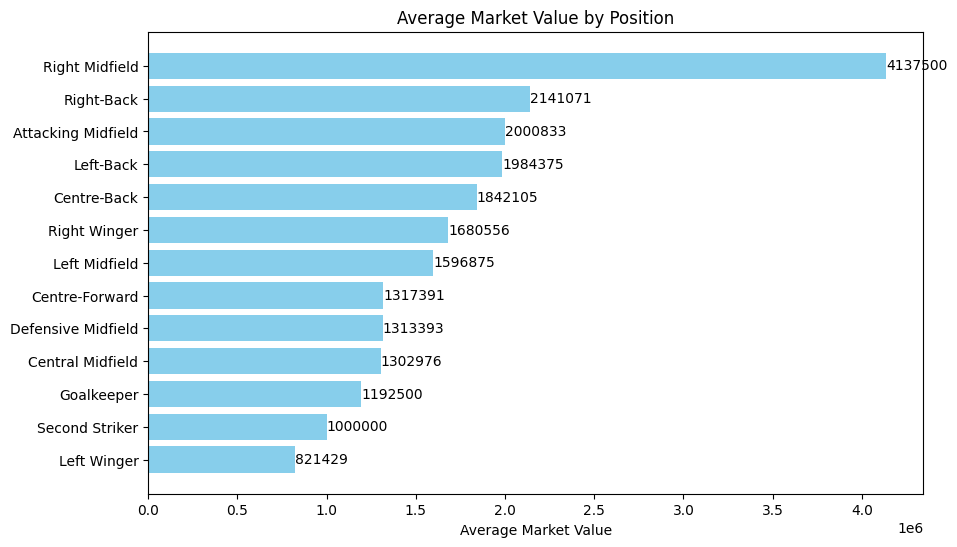

In [32]:
## IMPORTING THE MYSQL.CONNECTOR TO ESTABLISH CONNECTION WITH football_analysis_eda DATABASE IN MYSQL WORKBENCH
import mysql.connector as sql

## ESTABLISHING CONNECTION TO THE DATABASE football_analysis_eda
db = sql.connect(host='localhost', user='root',password='1234',database='football_analysis_eda')
# display(db)

## CREATING CURSOR OBJECT TO ACCESS THE TABLES WITHING
my_cursor = db.cursor()
# display(my_cursor)

# Accessing the view created in sql workbench
query = ''' SELECT * FROM PLAYER_POSITION_MKT_VALUE;'''
PLAYER_POSITION_MKT_VALUE = pd.read_sql_query(query, db)
db.close()
print('First 5 of dataframe')
display(PLAYER_POSITION_MKT_VALUE.sort_values(by = 'avg_market_value', ascending = False).head(5))

# Bar plot
plt.figure(figsize=(10, 6))
plt.barh(PLAYER_POSITION_MKT_VALUE['sub_position'], PLAYER_POSITION_MKT_VALUE['avg_market_value'], color='skyblue')
plt.gca().invert_yaxis()
for bar in plt.gca().containers:
    plt.bar_label(bar, fmt = '%.0f')
plt.xlabel('Average Market Value')
plt.title('Average Market Value by Position')
plt.show()

# 5. Is there any correlation between a player's height, market value? (TO BE DONE IN PYTHON ONLY VISUALIZATION NEEDED)

(152, 2)

,height_in_cm,market_value_in_eur
height_in_cm,1.00000,-0.03441
market_value_in_eur,-0.03441,1.00000


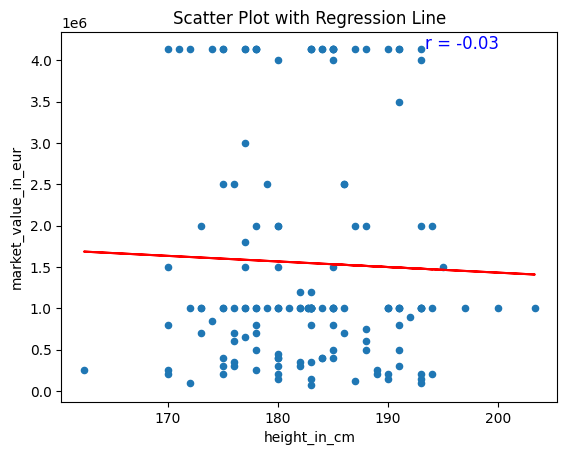

In [48]:
## IMPORTING THE MYSQL.CONNECTOR TO ESTABLISH CONNECTION WITH football_analysis_eda DATABASE IN MYSQL WORKBENCH
import mysql.connector as sql

## ESTABLISHING CONNECTION TO THE DATABASE football_analysis_eda
db = sql.connect(host='localhost', user='root',password='1234',database='football_analysis_eda')
# display(db)

## CREATING CURSOR OBJECT TO ACCESS THE TABLES WITHING
my_cursor = db.cursor()
# display(my_cursor)

# Accessing the view created in sql workbench
query = ''' SELECT * FROM PLAYER_HEIGHT_MKT_VAL;'''
PLAYER_HEIGHT_MKT_VAL = pd.read_sql_query(query, db)
db.close()

# print('First 5 of dataframe')
display(PLAYER_HEIGHT_MKT_VAL.shape)
display(PLAYER_HEIGHT_MKT_VAL.corr())
PLAYER_HEIGHT_MKT_VAL.plot(kind = 'scatter', x ='height_in_cm', y = 'market_value_in_eur')

# Calculate Pearson correlation coefficient
corr_coef = np.corrcoef(PLAYER_HEIGHT_MKT_VAL['height_in_cm'], PLAYER_HEIGHT_MKT_VAL['market_value_in_eur'])[0, 1]

# Add correlation coefficient on the plot
plt.text(PLAYER_HEIGHT_MKT_VAL['height_in_cm'].max() - 10, PLAYER_HEIGHT_MKT_VAL['market_value_in_eur'].max(),
         f'r = {corr_coef:.2f}', fontsize=12, color='blue')

# Fit a regression line
x = PLAYER_HEIGHT_MKT_VAL['height_in_cm']
y = PLAYER_HEIGHT_MKT_VAL['market_value_in_eur']

# Fit a line using numpy.polyfit
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope*x + intercept, color='red')  # Plot the line

plt.title('Scatter Plot with Regression Line')
plt.show()

# 6. Which players should the club invest in based on future potential and market demand?

(3568, 26)


In [29]:
# Merging the players and appearances table to get required columns
player_appearance_merge = pd.merge(players, appearances, left_on = ["player_id", "name"], right_on = ["player_id", "player_name"])
# print(player_appearance_merge.shape)

# Get Required columns and create total_contribution
player_market_val = player_appearance_merge.groupby(['player_id', 'name'])[["market_value_in_eur"]].mean() 
player_name_age = player_appearance_merge[['player_id', 'name', 'age', 'sub_position']].drop_duplicates(keep = 'first')

player_names_contribution = player_appearance_merge.groupby(['player_id', 'name'])[['goals', 'assists', 'minutes_played']].mean()
player_names_contribution['total_contribution'] = player_names_contribution['goals'] + player_names_contribution['assists']

# Merge the above to get the all players performance and market value
all_player_performance = pd.merge(player_name_age, player_names_contribution, on = ['player_id', 'name']).merge(player_market_val, 
                                                                                                                on = ['player_id', 'name'] )
all_player_performance
#### FURTHER ANALYSED IN EXCEL ####

,player_id,name,age,sub_position,goals,assists,minutes_played,total_contribution,market_value_in_eur
0,124732,John Anthony Brooks,31,Centre-Back,0.062147,0.033898,83.305085,0.096045,2000000.0
1,223047,Emerson Hyndman,28,Central Midfield,0.131579,0.105263,62.526316,0.236842,800000.0
2,307781,Lynden Gooch,29,Right Winger,0.000000,0.000000,33.090909,0.000000,1000000.0
3,370846,Timothy Weah,24,Right Midfield,0.222222,0.037037,30.481481,0.259259,4137500.0
4,72519,Bobby Wood,32,Centre-Forward,0.189873,0.050633,68.265823,0.240506,400000.0
...,...,...,...,...,...,...,...,...,...
87,273570,Desevio Payne,29,Right-Back,0.040000,0.000000,52.920000,0.040000,1000000.0
88,111783,Alejandro Bedoya,37,Central Midfield,0.126437,0.057471,70.540230,0.183908,300000.0
89,160670,Joe Gyau,32,Left Winger,0.000000,0.000000,22.000000,0.000000,400000.0
90,3476,Brad Friedel,53,Goalkeeper,0.000000,0.000000,91.111111,0.000000,1000000.0


# SAVING FILES TO EXCEL FOR POWERPOINT PRESENTATIONS